# Event Processing - TRex
Tasks:

Pseudocode to generate rules and events

Details in the paper: (Gianpaolo Cugola and Alessandro Margara. 2012. Complex event processingwith T-REX.Journal of Systems and Software85, 8 (2012), 1709–1728):

Each test was performed with 1000 different rules deployed, all having the same structure (that of Rule
R1 and Rule R2), but defining 10 different composite events (Fire1, defined from Temp1 and Smoke1, ..., Fire10, defined from Temp10 and Smoke10) and asking for a different minimum temperature (from 1 to 100). 

The value of the temperature of incoming Tempx events was uniformly distributed between 1
and 100, while all events shared the same area to maximize the probability of using events. Given these assumptions, each incoming event was selected by 50 different rules, on average.

How do these composite events differ from each other?

## Rules
Rule1
```sql
define 	Fire(area: string, measuredTemp: double)
from    Smoke(area=$a) and
		each Temp(area=$a and value>45)
		within 5 min. from Smoke
where 	area=Smoke.area and measuredTemp=Temp.value
```

Rule2
```sql
define 	Fire(area: string, measuredTemp: double)
from 	Smoke(area=$a) and
        last Temp(area=$a and value>45)
        within 5 min. from Smoke
where 	area=Smoke.area and measuredTemp=Temp.value
```

```sql
Assign 2000 => Smoke, 2001 => Temp, 2100 => Fire, 3000 => Smoke1, 3001 => Temp1, 3100 => Fire1

Define  Fire(area: string, measuredTemp: float)
From    Smoke(area=>$a) and each Temp([string]area=$a, value>45) within 300000 from Smoke
Where   area:=Smoke.area, measuredTemp:=Temp.value;

Define Fire1(area: string, measuredTemp: float)
From    Smoke1(area=>$a) and each Temp1([string]area=$a, value>45) within 300000 from Smoke1
Where   area:Smoke1.area, measuredTemp:=Temp1.value;
```

We create one file for each rule (10 different compositve events, 100 different temperature thresholds per composite event = 1000 rule files).
Then we have to inject each rule into the server using the java client.
Then we have to start a client and subscribe to all 10 composite events.

In [ ]:
smoke_id = 1000
temp_id = 1001
fire_id = 1100
file_idx = 0
for i in range(10):
    idx = i+1
    assign_line = f"Assign {smoke_id} => Smoke{idx}, {temp_id} => Temp{idx}, {fire_id} => Fire{idx}"
    smoke_id += 1000
    temp_id += 1000
    fire_id += 1000
    for temp_threshold in range(1,101):
        with open(f"trex_rules/trex1_{file_idx}.rule", mode="w", encoding="utf-8") as rule_file:
            rule_file.write(assign_line)
            rule1 = f"""Define  Fire{idx}(area: string, measuredTemp: float)
From    Smoke{idx}(area=>$a) and each Temp{idx}([string]area=$a, value>{temp_threshold}) within 300000 from Smoke{idx}
Where   area:=Smoke{idx}.area, measuredTemp:=Temp{idx}.value;"""
            rule_file.write("\n\n")
            rule_file.write(rule1)
            file_idx += 1

In [ ]:
smoke_id = 1000
temp_id = 1001
fire_id = 1100
file_idx = 0
for i in range(10):
    idx = i+1
    assign_line = f"Assign {smoke_id} => Smoke{idx}, {temp_id} => Temp{idx}, {fire_id} => Fire{idx}"
    smoke_id += 1000
    temp_id += 1000
    fire_id += 1000
    for temp_threshold in range(1,101):
        with open(f"trex_rules/trex2_{file_idx}.rule", mode="w", encoding="utf-8") as rule_file:
            rule_file.write(assign_line)
            rule2 = f"""Define  Fire{idx}(area: string, measuredTemp: float)
From    Smoke{idx}(area=>$a) and last Temp{idx}([string]area=$a, value>{temp_threshold}) within 300000 from Smoke{idx}
Where   area:=Smoke{idx}.area, measuredTemp:=Temp{idx}.value;"""
            rule_file.write("\n\n")
            rule_file.write(rule2)
            file_idx += 1

#### Injecting the rules
We have 1000 rule files for rule 1 and 1000 rule files for rule 2, each numbered from 0-999.

```bash
#!/bin/bash
# Bash script for loading the rule files corresponding to rule 1

for ((i = 0; i < 1000; i++)); do
        java -jar TRex-client.jar localhost 50254 -rule "trex_rules/trex1_$i.rule"
done
```

- Save this as `load_rule1.sh` in the TRex-Java-Client directory and run it from there.
- Make it executable with `sudo chmod u+x load_rule1.sh`
- After starting the TRex-Server with `TRexServer` you can run the script to inject all the rules: `./load_rule1.sh`
- This will probably take a while...

You can repeat the process for rule 2. You just have to replace the `1` with `2`.

The subscription command:

```java -jar TRex-client.jar localhost 50254 -sub 1100 2100 3100 4100 5100 6100 7100 8100 9100 10100```

## Events


Now we want to automate the process of event generation.

A few questions:
- How do we generate a ton of events according to an input rate?
- In which order do we generate Temp_x and Fire_x events? Random as well? But we have to create different loads (10%/50%/90% Smoke_x events and 90%/50%/10% Temp_x events) -> Random prob according to load
- Also do we randomly choose to publish e.g. Temp_1 and Fire_1 events vs. Temp_2 and Fire_2 events, i.e. do we alternate between the different composite events? -> Randomint

(A bug that I discovered when running the python script:

Even though I specified `float` for temperature values in the rules passing in floats via `java -jar TRex-client.jar localhost 50254 -pub {temp_id} area toto value {temperature}` does NOT work. You have to use `int`.)

In [ ]:
import random
import os

In [ ]:
load = 0.1  # 10% Smoke_x events
seconds = 10
measurement_intervals = 3
for i in range(measurement_intervals):
        n_call = 0
        t_end = time.time() + seconds
        while time.time() < t_end:
            n_call += 1
            temperature = round(random.uniform(0,100))
            composite_event_id = random.randint(1, 10)
            smoke_id = composite_event_id * 1000
            temp_id = composite_event_id * 1000 + 1
            if random.random() > load:
                os.system(f"java -jar TRex-client.jar localhost 50254 -pub {temp_id} area toto value {temperature}")
            else:
                os.system(f"java -jar TRex-client.jar localhost 50254 -pub {smoke_id} area toto")
        print(f"Measurement interval {i+1}: {n_call/seconds} events/seconds")

So a python script file `generate_events.py` may look like this:

```python
#!/usr/bin/env python3
import random
import os
import time


def publish_events(seconds, load, measurement_intervals):
    for i in range(measurement_intervals):
        n_call = 0
        t_end = time.time() + seconds
        while time.time() < t_end:
            n_call += 1
            temperature = round(random.uniform(0,100))
            composite_event_id = random.randint(1, 10)
            smoke_id = composite_event_id * 1000
            temp_id = composite_event_id * 1000 + 1
            if random.random() > load:
                os.system(f"java -jar TRex-client.jar localhost 50254 -pub {temp_id} area toto value {temperature}")
            else:
                os.system(f"java -jar TRex-client.jar localhost 50254 -pub {smoke_id} area toto")
        print(f"Measurement interval {i+1}: {n_call/seconds} events/seconds")


if __name__ == "__main__":
    publish_events(seconds=10, load=0.1, measurement_intervals=3)
```

## Experiments

For each rule and load scenario perform these steps:
- Start the TRexServer in one shell: `TRexServer > rule1_load_10.log` in `TRex/TRex-Server` (this writes the system output to a log file, set a different name for the currently used scenario/rule)
- In a separate shell load the rules using the bash script, e.g. for rule 1: `./load_rule1.sh` in `TRex/TRex-Java-client`
- Wait for the script to finish, then start a client that subscribes to all the Fire_x events: `java -jar TRex-client.jar localhost 50254 -sub 1100 2100 3100 4100 5100 6100 7100 8100 9100 10100`
- In a separate shell modify the load variable in `TRex/TRex-Java-client/generate_events.py`, e.g. to 0.1 for load 10% Smoke_x events and then run the script `python generate_events.py` in `TRex/TRex-Java-client`
- Quit the client and server, then proceed with the next rule/scenario

# Working with the logs
The most relevant lines in the log files look like this:

> Latency: 365ms

> Throughput rate: 0.444114Pkt/s

We now extract the latency and throughput measurements from the lines.

Note that I ran the experiment for each load scenario for 30 seconds.
So I wonder why there are so many throughput rate lines if the throughput rate was measured over a 10 seconds interval...
Latency and throughput measurements are done each time handleResults method is called.

I assume the following log files:
- rule1_load_10.log
- rule1_load_50.log
- rule1_load_90.log
- rule2_load_10.log
- rule2_load_50.log
- rule2_load_90.log

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
log_dir = "logs/run02/"

In [3]:
input_rates = {
    "rule1": {
        "load10": [17.933333333333334, 17.8666666666666670, 18.0],
        "load50": [18.6, 17.9333333333333340, 17.666666666666668],
        "load90": [18.066666666666666, 18.0, 18.0]
    },
    "rule2": {
        "load10": [18.6, 18.533333333333335, 18.6],
        "load50": [18.066666666666666, 18.2, 18.266666666666666],
        "load90": [18.333333333333332, 18.333333333333332, 18.266666666666666]
    }
}

In [4]:
input_rates_flattened = [17.933333333333334, 17.8666666666666670, 18.0, 18.6, 17.9333333333333340, 17.666666666666668, 18.066666666666666, 18.0, 18.0, 18.6, 18.533333333333335, 18.6, 18.066666666666666, 18.2, 18.266666666666666, 18.333333333333332, 18.333333333333332, 18.266666666666666]
print(f"Input rates (mean+/-std): {np.mean(input_rates_flattened)}+/-{np.std(input_rates_flattened)} events/s")

Input rates (mean+/-std): 18.181481481481477+/-0.27107973912800376 events/s


In [5]:
def get_data_from_log(log_file_path):
    throughput_rates = []
    latencies = []
    latency_prefix_len = len("Latency: ")
    latency_suffix_len = len("ms\n")
    throughput_prefix_len = len("Throughput rate: ")
    throughput_suffix_len = len("Pkt/s\n")
    with open(log_file_path, mode="r", encoding="utf-8") as f:
        for line in f.readlines():
            if line.startswith("Latency"):
                latency = int(line[latency_prefix_len:-latency_suffix_len])
                latencies.append(latency)
            elif line.startswith("Throughput rate"):
                throughput_rate = float(line[throughput_prefix_len:-throughput_suffix_len])
                throughput_rates.append(throughput_rate)
    return throughput_rates, latencies

In [6]:
def calculate_stats(data):
    return {
        "min": np.min(data), 
        "max": np.max(data), 
        "mean": np.mean(data), 
        "median": np.median(data),
        "std": np.std(data)
    }

In [7]:
def get_rule_measurements(rule_no=1, log_dir="logs/"):
    rule_measurements = {}
    for load in [10, 50, 90]:
        throughput_rates, latencies = get_data_from_log(log_dir + f"rule{rule_no}_load_{load}.log")
        rule_measurements[f"load{load}"] = {
            "input_rates": input_rates[f"rule{rule_no}"][f"load{load}"],
            "latencies": latencies,
            "throughput_rates": throughput_rates,
            "latencies_stats": calculate_stats(latencies),
            "throughput_rates_stats": calculate_stats(throughput_rates),
        }
    return rule_measurements

In [8]:
rule1_measurements = get_rule_measurements(rule_no=1, log_dir=log_dir)

In [9]:
pd.DataFrame(rule1_measurements).to_json("rule1_measurements.json")

In [10]:
rule2_measurements = get_rule_measurements(rule_no=2, log_dir=log_dir)

In [11]:
pd.DataFrame(rule2_measurements).to_json("rule2_measurements.json")

In [12]:
def print_stats(rule_measurements, rule_no):
    print(f"--------Rule{rule_no}-----------")
    for load in [10, 50, 90]:
        latency_stats = rule_measurements[f"load{load}"]["latencies_stats"]
        print(f"Latency stats for load {load}%: \n {latency_stats}")
        throughput_rate_stats = rule_measurements[f"load{load}"]["throughput_rates_stats"]
        print(f"Throughput rate stats for load {load}%: \n {throughput_rate_stats}")
        print("\n")

In [13]:
def get_load_latencies(rule_measurements):
    load_latencies = {
        "load": [],
        "latency": [] 
    }
    for load in [10, 50, 90]:
        latencies = rule_measurements[f"load{load}"]["latencies"]
        load_latencies["latency"] += latencies
        load_latencies["load"] += [load for i in range(len(latencies))]
    return pd.DataFrame(load_latencies)

def get_load_throughput_rates(rule_measurements):
    load_throughput_rates = {
        "load": [],
        "throughput_rate": [] 
    }
    for load in [10, 50, 90]:
        throughput_rates = rule_measurements[f"load{load}"]["throughput_rates"]
        load_throughput_rates["throughput_rate"] += throughput_rates
        load_throughput_rates["load"] += [load for i in range(len(throughput_rates))]
    return pd.DataFrame(load_throughput_rates)

### Rule 1 Results

In [14]:
print_stats(rule1_measurements, rule_no=1)

--------Rule1-----------
Latency stats for load 10%: 
 {'min': 243, 'max': 3357, 'mean': 478.96158612143745, 'median': 319.0, 'std': 478.9458760443482}
Throughput rate stats for load 10%: 
 {'min': 0.0, 'max': 20.8204, 'mean': 1.2217411811414394, 'median': 0.0, 'std': 3.846907148253894}


Latency stats for load 50%: 
 {'min': 253, 'max': 2401, 'mean': 652.9962686567164, 'median': 397.0, 'std': 461.6869389403031}
Throughput rate stats for load 50%: 
 {'min': 0.0, 'max': 14.118, 'mean': 3.23010211442786, 'median': 0.629883, 'std': 4.113089846230165}


Latency stats for load 90%: 
 {'min': 252, 'max': 962, 'mean': 464.3403205918619, 'median': 441.0, 'std': 134.36366020292763}
Throughput rate stats for load 90%: 
 {'min': 0.0, 'max': 3.78999, 'mean': 1.1553408621975307, 'median': 0.823427, 'std': 1.1032484181355893}




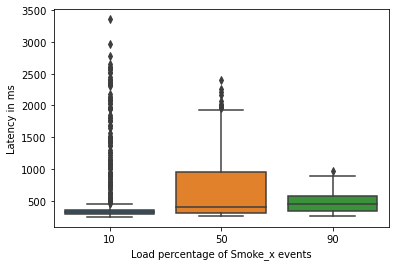

In [15]:
ax = sns.boxplot(data=get_load_latencies(rule1_measurements), x="load", y="latency")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Latency in ms')
fig = ax.get_figure()
fig.savefig("rule1_latency_boxplot.pdf")
plt.show()

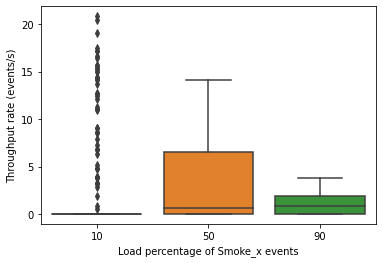

In [16]:
ax = sns.boxplot(data=get_load_throughput_rates(rule1_measurements), x="load", y="throughput_rate")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Throughput rate (events/s)')
fig = ax.get_figure()
fig.savefig("rule1_throughput_rate_boxplot.pdf")
plt.show()

### Rule 2 Results

In [17]:
print_stats(rule2_measurements, rule_no=2)

--------Rule2-----------
Latency stats for load 10%: 
 {'min': 249, 'max': 561, 'mean': 317.3612440191388, 'median': 311.0, 'std': 43.36300686071776}
Throughput rate stats for load 10%: 
 {'min': 0.0, 'max': 0.582355, 'mean': 0.036441624401913876, 'median': 0.0, 'std': 0.1318883285700447}


Latency stats for load 50%: 
 {'min': 254, 'max': 858, 'mean': 364.81418092909536, 'median': 342.0, 'std': 74.6679835643189}
Throughput rate stats for load 50%: 
 {'min': 0.0, 'max': 0.67208, 'mean': 0.2768530024449878, 'median': 0.0, 'std': 0.28118251421228313}


Latency stats for load 90%: 
 {'min': 251, 'max': 678, 'mean': 377.65412621359224, 'median': 356.0, 'std': 67.79008528233322}
Throughput rate stats for load 90%: 
 {'min': 0.0, 'max': 0.832229, 'mean': 0.43036040485436894, 'median': 0.5342355000000001, 'std': 0.2696770151372294}




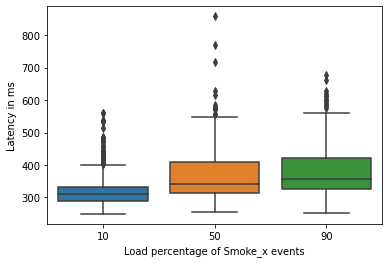

In [18]:
ax = sns.boxplot(data=get_load_latencies(rule2_measurements), x="load", y="latency")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Latency in ms')
fig = ax.get_figure()
fig.savefig("rule2_latency_boxplot.pdf")
plt.show()

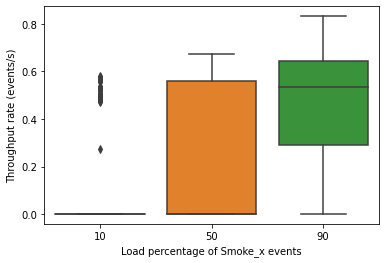

In [19]:
ax = sns.boxplot(data=get_load_throughput_rates(rule2_measurements), x="load", y="throughput_rate")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Throughput rate (events/s)')
fig = ax.get_figure()
fig.savefig("rule2_throughput_rate_boxplot.pdf")
plt.show()

## Another attempt at throughput measurement

I logged the PubPacket received messages from the subscribing client. 

For reference, typical output from the subscribed client looks like this:

> PubPacket received: {4100 <area : string = toto> <measuredTemp : float = 77.0>}@Jul 7, 2021 5:27:12 PM
    
> PubPacket received: {4100 <area : string = toto> <measuredTemp : float = 77.0>}@Jul 7, 2021 5:27:12 PM

> PubPacket received: {7100 <area : string = toto> <measuredTemp : float = 81.0>}@Jul 7, 2021 5:27:13 PM
    

If we count the number of received PubPackets (corresponding to generated Fire events) per unique time stamp that would also give an estimate of the throughput rate.

In [20]:
import numpy as np
import pandas as pd

In [21]:
def get_throughput_from_pub_packets(log_path):
    timestamps = []
    with open(log_path, mode="r", encoding="utf-8") as f:
        for line in f.readlines():
            timestamps.append(line.split("@")[-1])
    uniques, counts = np.unique(timestamps, return_counts=True)
    return uniques, counts

In [22]:
def print_throughputs(rule_no, log_dir="logs/run02/"):
    for load in [10, 50, 90]:
        log_path = log_dir + f"rule{rule_no}_load_{load}_pubpacket.log"
        uniques, throughput_rates = get_throughput_from_pub_packets(log_path)
        mean = np.mean(throughput_rates)
        std = np.std(throughput_rates)
        print(f"Load {load}% Smoke_x events: {mean}+/-{std} events/s")
        print(throughput_rates)
        print("\n")

In [23]:
def get_throughputs_per_load(rule_no, log_dir="logs/run02/"):
    load_throughput_rates = {
        "load": [],
        "throughput_rate": [] 
    }
    for load in [10, 50, 90]:
        log_path = log_dir + f"rule{rule_no}_load_{load}_pubpacket.log"
        uniques, throughput_rates = get_throughput_from_pub_packets(log_path)
        load_throughput_rates["throughput_rate"] += list(throughput_rates)
        load_throughput_rates["load"] += [load for i in range(len(throughput_rates))]
    return pd.DataFrame(load_throughput_rates)

In [24]:
rule1_throughput_rates = get_throughputs_per_load(rule_no=1, log_dir="logs/run02/")

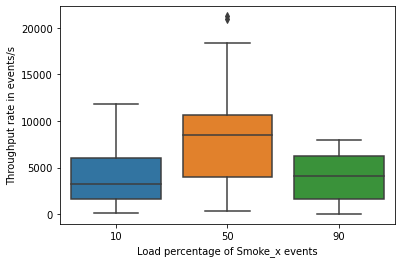

In [25]:
ax = sns.boxplot(data=rule1_throughput_rates, x="load", y="throughput_rate")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Throughput rate in events/s')
fig = ax.get_figure()
fig.savefig("rule1_throughput_pubpacket_boxplot.pdf")
plt.show()

Code to generate separate line plots for each rule & load scenario:

```python
rule_no = 1
N = 5
for load in [10, 50, 90]:
    uniques, throughput_rates = get_throughput_from_pub_packets(log_path=f"logs/run02/rule{rule_no}_load_{load}_pubpacket.log")
    mv_avg = list(np.convolve(throughput_rates, np.ones(N)/N, mode='valid'))
    ax = sns.lineplot(x=[i for i in range(1, len(mv_avg)+1)], y=mv_avg)
    ax.set(xlabel='Number seconds passed', ylabel='Throughput rate in events/s')
    fig = ax.get_figure()
    plt.show()
```

In [26]:
def get_throughput_data_for_lineplot(rule_no=1, mv_avg_window=5):
    throughput_rates_to_plot = []
    loads_per_load = []
    mv_avgs_per_load = []
    for load in [10, 50, 90]:
        uniques, throughput_rates = get_throughput_from_pub_packets(log_path=f"logs/run02/rule{rule_no}_load_{load}_pubpacket.log")
        mv_avg = list(np.convolve(throughput_rates, np.ones(mv_avg_window)/mv_avg_window, mode='valid'))
        mv_avgs_per_load.append(mv_avg)
        loads_per_load.append([load for i in mv_avg])

    list_length = min([len(e) for e in mv_avgs_per_load])

    for loads, mv_avgs in zip(loads_per_load, mv_avgs_per_load):
        second = 1
        for load, throughput_rate in zip(loads[:list_length], mv_avgs[:list_length]):
            throughput_rates_to_plot.append({
                "second": second,
                "load": load,
                "throughput_rate": throughput_rate
            })
            second += 1
    return throughput_rates_to_plot

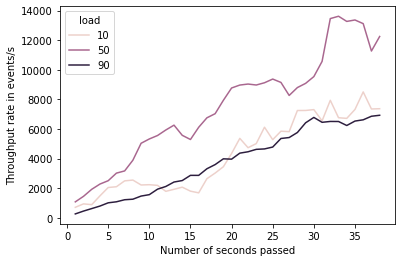

In [27]:
throughput_rates_to_plot = get_throughput_data_for_lineplot(rule_no=1, mv_avg_window=5)
ax = sns.lineplot(data=pd.DataFrame(throughput_rates_to_plot), x="second", y="throughput_rate", hue="load")
ax.set(xlabel='Number of seconds passed', ylabel='Throughput rate in events/s')
fig = ax.get_figure()
fig.savefig("rule1_throughput_pubpacket_lineplot.pdf")
plt.show()

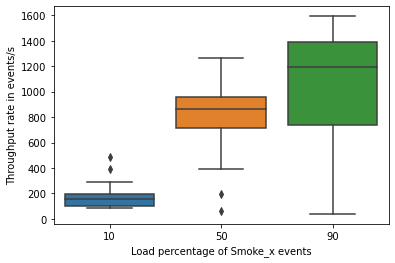

In [28]:
rule2_throughput_rates = get_throughputs_per_load(rule_no=2, log_dir="logs/run02/")
ax = sns.boxplot(data=rule2_throughput_rates, x="load", y="throughput_rate")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Throughput rate in events/s')
fig = ax.get_figure()
fig.savefig("rule2_throughput_pubpacket_boxplot.pdf")
plt.show()

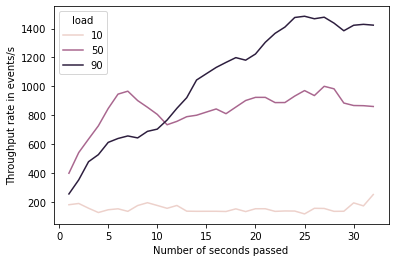

In [34]:
throughput_rates_to_plot = get_throughput_data_for_lineplot(rule_no=2, mv_avg_window=5)
ax = sns.lineplot(data=pd.DataFrame(throughput_rates_to_plot), x="second", y="throughput_rate", hue="load")
ax.set(xlabel='Number of seconds passed', ylabel='Throughput rate in events/s')
fig = ax.get_figure()
fig.savefig("rule2_throughput_pubpacket_lineplot.pdf")
plt.show()

In [30]:
print_throughputs(rule_no=1, log_dir="logs/run02/")

Load 10% Smoke_x events: 4157.452380952381+/-3264.60727020645 events/s
[   76   752   298   672  1713  1243   493  3272  3487  1981  3224   762
  1614  3580  1757  1203  1447  2339  2233  1182  5995  3343  4479  6721
  6284  2842  4730 10020  2502  9154  2691 11873 10038  2788  5356  9635
  5985  9818  5806 11280  3867  6078]


Load 50% Smoke_x events: 8213.760869565218+/-5108.80297468213 events/s
[  290   359  1141  1828  1739  2164  2737  2912  2957  4302  2911  6353
  8643  4415  5470  4766  7999  5209  2995  9601  7968  9392  9730  7162
 10594  8309  9066 10490  8416  9456  3905 11731 11911 10702 14589 18383
 12523 10162 11189 13349  9128 17438 20992 21253 11236  9968]


Load 90% Smoke_x events: 3937.4545454545455+/-2487.1746699504192 events/s
[   2    1  211  448  622  962  847 1064 1542  967 1658 1027 2122 2020
 2824 2565 2532 2618 3781 2817 4804 3939 4565 3672 4850 5266 4758 4708
 4308 7744 5587 6460 7993 6119 6094 5877 6443 6641 7616 6521 7080 6774
 7214 7585]




In [31]:
rule2_throughput_rates = get_throughputs_per_load(rule_no=2, log_dir="logs/run02/")

In [32]:
print_throughputs(rule_no=2, log_dir="logs/run02/")

Load 10% Smoke_x events: 167.0+/-89.2873015731925 events/s
[143 251 248  98 163 186  87  99 194 196  98 288 197  98  98 196  91 192
  99  98 189 182  98 197  98  98 196  95  98 292  93  96  98 388 188 486]


Load 50% Smoke_x events: 823.2826086956521+/-242.2792731937292 events/s
[  60  420  434  388  690  776  887  892  987 1188  878  562  660  741
  829  996  723  711  850  937  832  952  938  959  937  651  954 1162
 1149  764  972  867  670 1063  758  944  844  671  976  861  975  784
 1268  956 1161  194]


Load 90% Smoke_x events: 1083.0217391304348+/-429.2206025045475 events/s
[  38   88  262  406  482  526  716  506  830  617  614  648  733  907
  932 1020 1015 1344 1126 1149 1194 1180 1256 1339 1554 1505 1396 1588
 1382 1467 1559 1191 1324 1572 1499 1531 1160 1339 1361 1591 1529 1295
 1387 1307 1592  762]




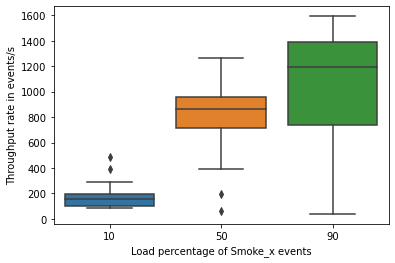

In [33]:
ax = sns.boxplot(data=rule2_throughput_rates, x="load", y="throughput_rate")
ax.set(xlabel='Load percentage of Smoke_x events', ylabel='Throughput rate in events/s')
fig = ax.get_figure()
fig.savefig("rule2_throughput_pubpacket_boxplot.pdf")
plt.show()